In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
import torchvision
import PIL.Image as Image
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [81]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample, step=0):
        super().__init__()
        self.downsample = downsample
        self.step = step
        self.linear1 = nn.Linear(6400, 6400, bias=False)
        self.linear2 = nn.Linear(6400, 6400, bias=False)
        self.linear3 = nn.Linear(3200, 3200, bias=False)
        self.linear4 = nn.Linear(2304, 2304, bias=False)
        self.linear5 = nn.Linear(2048, 2048, bias=False)
        with torch.no_grad():
            self.linear1.weight.copy_(torch.diag(torch.ones(6400)))
            self.linear2.weight.copy_(torch.diag(torch.ones(6400)))
            self.linear3.weight.copy_(torch.diag(torch.ones(3200)))
            self.linear4.weight.copy_(torch.diag(torch.ones(2304)))
            self.linear5.weight.copy_(torch.diag(torch.ones(2048)))
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            if (step == 1):
              self.shortcut = self.linear1
            elif (step == 2):
              self.shortcut = self.linear2
            elif (step == 3):
              self.shortcut = self.linear3
            elif (step == 4):
              self.shortcut = self.linear4
            elif (step == 5):
              self.shortcut = self.linear5
            else:
              self.shortcut = nn.Sequential()
            

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        if not self.downsample:
          with torch.no_grad():
            size = input.size()
            shortcut = self.shortcut(torch.flatten(input,1))
            shortcut = shortcut.view(size)
        else:
          shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [85]:

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=10):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False, step=1),
            resblock(64, 64, downsample=False, step=2)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=torch.triu_indices),
            resblock(128, 128, downsample=False, step=3)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False, step=4)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False, step=5)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input,1)
        input = self.fc(input)

        return input

In [35]:
print(linearresnet18.layer1[0].linear1.weight)

Parameter containing:
tensor([[-0.0087, -0.1319, -0.1677,  0.2035,  0.0795,  0.5050,  0.2319,  0.4242,
         -0.1260, -0.0580],
        [ 0.0096, -0.3695,  0.4472,  0.4150,  0.2573,  0.3605, -0.1696, -0.2289,
         -0.8149,  0.0557],
        [-0.0715, -0.0217,  0.3610,  0.0816,  0.2653, -0.2168,  0.1259, -0.2235,
          0.0927, -0.0439],
        [ 0.0017, -0.2445, -0.4009,  0.2120, -0.3003,  0.2513,  0.2494,  0.1950,
          0.0097, -0.0686],
        [ 0.0064, -0.1035,  0.0762, -0.4001,  0.2681,  0.2209, -0.2652,  0.0545,
         -0.0534,  0.1779],
        [-0.0618,  0.2049,  0.0599,  0.0117, -0.2003, -0.1734, -0.1093, -0.0065,
         -0.0152, -0.2243],
        [-0.0076, -0.0059, -0.0760, -0.1367, -0.1255, -0.0340, -0.0728, -0.2790,
          0.0516, -0.1375],
        [-0.1885, -0.2722, -0.3489, -0.0792,  0.3874,  0.0268,  0.1068,  0.1169,
          0.1276, -0.2591],
        [-0.0390, -0.0973,  0.3041,  0.4352,  0.1636, -0.3245, -0.1194, -0.4137,
          0.0480,  0.1600

In [40]:
class Linear_ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample, step=0):
        super().__init__()
        self.downsample = downsample
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(5, 5)
        self.linear4 = nn.Linear(3, 3)
        self.linear5 = nn.Linear(2, 2)
        with torch.no_grad():
            self.linear1.weight.copy_(torch.diag(torch.ones(10)))
            self.linear2.weight.copy_(torch.diag(torch.ones(10)))
            self.linear3.weight.copy_(torch.diag(torch.ones(5)))
            self.linear4.weight.copy_(torch.diag(torch.ones(3)))
            self.linear5.weight.copy_(torch.diag(torch.ones(2)))

        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            if (step == 1):
              self.shortcut = self.linear1
            elif (step == 2):
              self.shortcut = self.linear2
            elif (step == 3):
              self.shortcut = self.linear3
            elif (step == 4):
              self.shortcut = self.linear4
            elif (step == 5):
              self.shortcut = self.linear5
            else:
              self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        size = input.size()
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [6]:

class Linear_ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=10):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False, step=1),
            resblock(64, 64, downsample=False, step=2)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False, step=3)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False, step=4)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False, step=5)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input,1)
        input = self.fc(input)

        return input

In [7]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 64

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [86]:
resnet18 = ResNet18(3, ResBlock).to(device)

In [87]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# torch.optim.SGD(model.parameters(), lr=learning_rate)  
criterion = torch.nn.CrossEntropyLoss()

In [80]:
print(resnet18.layer1[0].linear1.bias)

Parameter containing:
tensor([ 0.0088, -0.0043, -0.0103,  ..., -0.0107, -0.0085, -0.0096],
       device='cuda:0', requires_grad=True)


In [88]:
num_epochs = 20
avgLoss = []
test_avgLoss = []
train_acc = []
test_acc = []
# Training the Model
for epoch in range(num_epochs):
    total_loss = 0
    cnt = 0
    train_cnt = 0
    train_correct = 0
    for i, (images, labels) in enumerate(tqdm(train_cifar_loader)):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        predict = torch.argmax(outputs, dim=1)
        cnt += 1
        train_cnt += labels.size()[0]
        train_correct += (predict == labels).sum()
    avgLoss.append(total_loss/cnt)
    train_acc.append(train_correct/train_cnt)
    test_cnt = 0
    test_correct = 0
    test_total_loss = 0
    test_loss_cnt = 0
  
    for test_i, (test_images, test_labels) in enumerate(test_cifar_loader):
      test_images = test_images.to(device)
      test_labels = test_labels.to(device)
      test_cnt += test_labels.size()[0]
      test_loss_cnt += 1
      test_out = resnet18(test_images)
      test_loss = criterion(test_out, test_labels)
      test_total_loss += test_loss.item()
      test_correct += (torch.argmax(test_out, dim=1) == test_labels).sum()
    test_avgLoss.append(test_total_loss/test_loss_cnt)
    test_acc.append(test_correct/test_cnt)

    print("Number of epochs: %d\n Train Loss: %f\n Train Acc: %f\n Test Acc: %f" % (epoch, total_loss/cnt, train_correct/train_cnt, test_correct/test_cnt))

  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 0
 Train Loss: 1.472104
 Train Acc: 0.457700
 Test Acc: 0.560700


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 1
 Train Loss: 1.133591
 Train Acc: 0.594840
 Test Acc: 0.632200


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 2
 Train Loss: 0.969976
 Train Acc: 0.658520
 Test Acc: 0.665500


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 3
 Train Loss: 0.860959
 Train Acc: 0.702960
 Test Acc: 0.688400


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 4
 Train Loss: 0.761761
 Train Acc: 0.739100
 Test Acc: 0.716500


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 5
 Train Loss: 0.687138
 Train Acc: 0.764480
 Test Acc: 0.719700


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 6
 Train Loss: 0.620117
 Train Acc: 0.788520
 Test Acc: 0.742500


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 7
 Train Loss: 0.553430
 Train Acc: 0.812760
 Test Acc: 0.739600


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 8
 Train Loss: 0.502421
 Train Acc: 0.828940
 Test Acc: 0.739600


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 9
 Train Loss: 0.446530
 Train Acc: 0.848680
 Test Acc: 0.750300


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 10
 Train Loss: 0.406855
 Train Acc: 0.863220
 Test Acc: 0.746100


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 11
 Train Loss: 0.375746
 Train Acc: 0.871200
 Test Acc: 0.748300


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 12
 Train Loss: 0.333292
 Train Acc: 0.887460
 Test Acc: 0.748800


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 13
 Train Loss: 0.304832
 Train Acc: 0.895820
 Test Acc: 0.755000


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 14
 Train Loss: 0.288223
 Train Acc: 0.903420
 Test Acc: 0.749800


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 15
 Train Loss: 0.258707
 Train Acc: 0.910340
 Test Acc: 0.745200


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 16
 Train Loss: 0.243286
 Train Acc: 0.916880
 Test Acc: 0.747100


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 17
 Train Loss: 0.221026
 Train Acc: 0.924380
 Test Acc: 0.750100


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 18
 Train Loss: 0.210515
 Train Acc: 0.929480
 Test Acc: 0.750700


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 19
 Train Loss: 0.193678
 Train Acc: 0.934800
 Test Acc: 0.755800


In [43]:
linearresnet18 = Linear_ResNet18(3, Linear_ResBlock).to(device)
optimizer2 = torch.optim.Adam(linearresnet18.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# torch.optim.SGD(model.parameters(), lr=learning_rate)  
criterion2 = torch.nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
linearresnet18 = linearresnet18.to(device)

In [44]:
num_epochs = 20
avgLoss2 = []
test_avgLoss2 = []
train_acc2 = []
test_acc2 = []
# Training the Model
for epoch in range(num_epochs):
    total_loss = 0
    cnt = 0
    train_cnt = 0
    train_correct = 0
    for i, (images, labels) in enumerate(tqdm(train_cifar_loader)):
        images = images.to(device)
        labels = labels.to(device)
        optimizer2.zero_grad()
        outputs = linearresnet18(images)
        loss = criterion2(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer2.step()
        predict = torch.argmax(outputs, dim=1)
        cnt += 1
        train_cnt += labels.size()[0]
        train_correct += (predict == labels).sum()
    avgLoss2.append(total_loss/cnt)
    train_acc2.append(train_correct/train_cnt)
    test_cnt = 0
    test_correct = 0
    test_total_loss = 0
    test_loss_cnt = 0
  
    for test_i, (test_images, test_labels) in enumerate(test_cifar_loader):
      test_images = test_images.to(device)
      test_labels = test_labels.to(device)
      test_cnt += test_labels.size()[0]
      test_loss_cnt += 1
      test_out = linearresnet18(test_images)
      test_loss = criterion2(test_out, test_labels)
      test_total_loss += test_loss.item()
      test_correct += (torch.argmax(test_out, dim=1) == test_labels).sum()
    test_avgLoss2.append(test_total_loss/test_loss_cnt)
    test_acc2.append(test_correct/test_cnt)

    print("Number of epochs: %d\n Train Loss: %f\n Train Acc: %f\n Test Acc: %f" % (epoch, total_loss/cnt, train_correct/train_cnt, test_correct/test_cnt))

  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 0
 Train Loss: 1.286676
 Train Acc: 0.534800
 Test Acc: 0.627400


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 1
 Train Loss: 0.910264
 Train Acc: 0.682560
 Test Acc: 0.683400


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 2
 Train Loss: 0.751081
 Train Acc: 0.737920
 Test Acc: 0.728500


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 3
 Train Loss: 0.631209
 Train Acc: 0.780720
 Test Acc: 0.746000


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 4
 Train Loss: 0.534791
 Train Acc: 0.812880
 Test Acc: 0.749900


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 5
 Train Loss: 0.438184
 Train Acc: 0.847340
 Test Acc: 0.748000


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 6
 Train Loss: 0.359677
 Train Acc: 0.875920
 Test Acc: 0.753700


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 7
 Train Loss: 0.292993
 Train Acc: 0.898000
 Test Acc: 0.758200


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 8
 Train Loss: 0.233664
 Train Acc: 0.919340
 Test Acc: 0.755500


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 9
 Train Loss: 0.205103
 Train Acc: 0.928060
 Test Acc: 0.755400


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 10
 Train Loss: 0.172595
 Train Acc: 0.939940
 Test Acc: 0.752200


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 11
 Train Loss: 0.157718
 Train Acc: 0.945160
 Test Acc: 0.762600


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 12
 Train Loss: 0.139709
 Train Acc: 0.950420
 Test Acc: 0.752900


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 13
 Train Loss: 0.130863
 Train Acc: 0.954360
 Test Acc: 0.752500


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 14
 Train Loss: 0.120252
 Train Acc: 0.958120
 Test Acc: 0.749900


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 15
 Train Loss: 0.119266
 Train Acc: 0.958960
 Test Acc: 0.753100


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 16
 Train Loss: 0.113595
 Train Acc: 0.960380
 Test Acc: 0.753600


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 17
 Train Loss: 0.107261
 Train Acc: 0.963520
 Test Acc: 0.759200


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 18
 Train Loss: 0.103777
 Train Acc: 0.964140
 Test Acc: 0.734900


  0%|          | 0/782 [00:00<?, ?it/s]

Number of epochs: 19
 Train Loss: 0.104620
 Train Acc: 0.963240
 Test Acc: 0.755700


In [ ]:
print(staticres18.layer1[0].linear1.weight)

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', requires_grad=True)


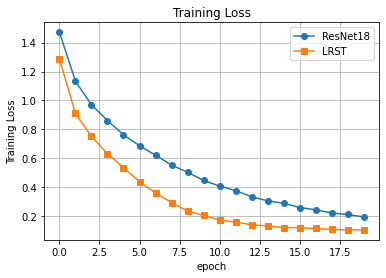

In [178]:
plt.plot(np.transpose(avgLoss), 'o-',label = "ResNet18")
plt.plot(np.transpose(avgLoss2), 's-', label = "LRST")
plt.grid('True')
plt.xlabel("epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss")
plt.show()

In [103]:
for i in range(len(test_acc)):
  test_acc[i] = test_acc[i].detach().cpu().numpy()

In [106]:
for i in range(len(test_acc2)):
  test_acc2[i] = test_acc2[i].detach().cpu().numpy()

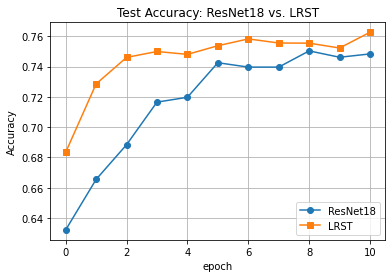

In [179]:
plt.plot(test_acc[1:12], 'o-', label = "ResNet18")
plt.plot(test_acc2[1:12], 's-', label = "LRST")
plt.grid('True')
plt.legend()
plt.title("Test Accuracy: ResNet18 vs. LRST")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()

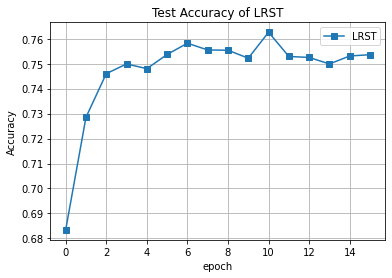

In [180]:

plt.plot(test_acc2[1:17], 's-', label = "LRST")
plt.grid('True')
plt.legend()

plt.title("Test Accuracy of LRST")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()

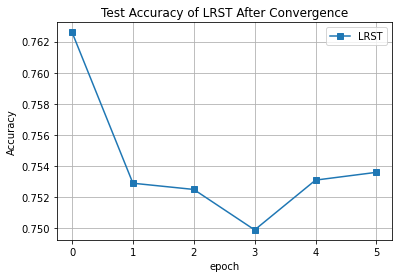

In [181]:
plt.plot(test_acc2[11:17], 's-', label = "LRST")
plt.grid('True')
plt.legend()
plt.title("Test Accuracy of LRST After Convergence")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()

In [170]:
for i in range(len(train_acc2)):
  train_acc2[i] = train_acc2[i].detach().cpu().numpy()

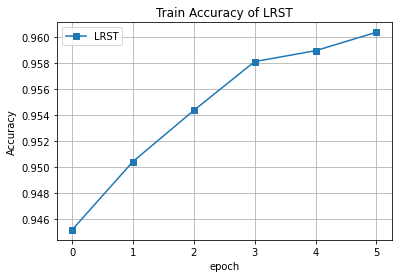

In [182]:
plt.plot(train_acc2[11:17], 's-', label = "LRST")
plt.grid('True')
plt.legend()
plt.title("Train Accuracy of LRST")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()